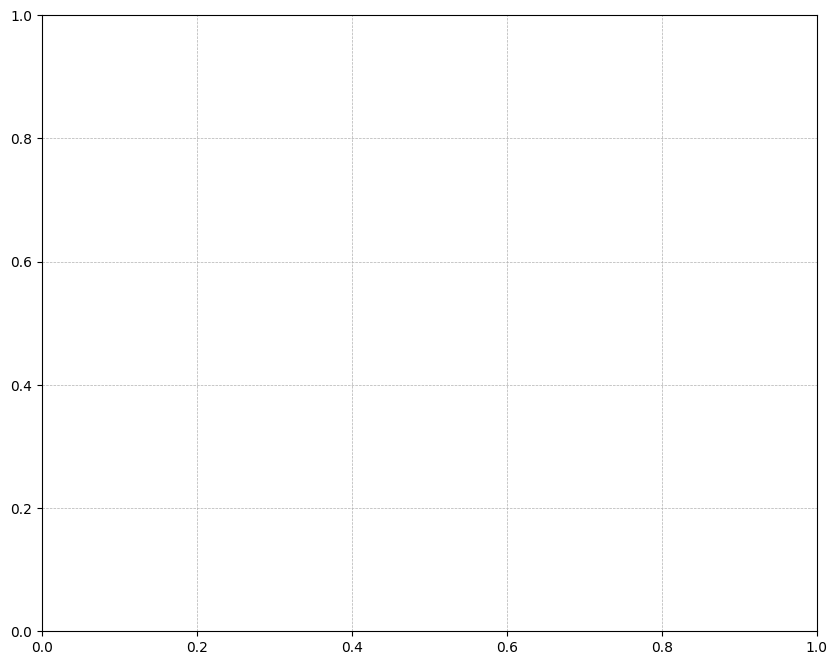

In [44]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.logistic_regression import log_loss_ridge, import_breast_cancer, accuracy_func, logistic_loss_func, logistic_grad, ridge_term, true_pos_variable_func, false_pos_variable_func
from Code.utilities import train_test_split, plot_test_results
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam, SGD, GD
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import numpy as np
from jax import nn, grad, jit, pmap



In [45]:
X, y = import_breast_cancer()
X = jnp.array(X)
y = jnp.array(y)
print(jnp.count_nonzero(y))
print(y.shape)


239
(683,)


c:\Users\eirik\Desktop\UIO\FYSSTK\Project2_FYS_STK4155\Code\logistic_regression.py:48: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  X = jnp.array(data.to_numpy()[:, 1:-1], dtype=jnp.float64)


In [60]:
def single_run(X, y, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, test_index=None):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)

    epochs = 100

    model = jit(get_neural_network_model(hidden_layer_num ,activation=hidden_activation, output_activation=nn.sigmoid))

    #loss_func = logistic_loss_func(model=model)
    loss_func = jit(log_loss_ridge(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    #print(loss_grad(beta0, X, y))


    test_func = jit(accuracy_func(model))

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)
    #result = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)

    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    #plot_test_results(result["test_loss_list"], result["train_loss_list"], 5)
    #result2 = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=loss_func, lr=lr)
    #plot_test_results(result2["test_loss_list"], result2["train_loss_list"], 5)


    return result





result = single_run(X, y, 3e-3, 0.000, hidden_layer_num=3, node_per_hidden=5, hidden_activation=nn.sigmoid)
print("Log run")
#result = single_run(X, y, 0.01, 0.001, 0, 5, hidden_activation=nn.relu)



Log run


### Note for report

When initializing the parameters with only positive values we get a tendency that the initial output gets bigger and bigger the larger the model. This caused the model to predict 1 in all training examples(after sigmoid) and so the gradient became zero everywhere and the model got stuck. When initializing with negative and positive values we got more varied outputs and nonzero gradients and so the model managed to start learning.


When running the model with a very low learning rate we see that the model is slowly decreasing in the loss function used to optimize, but sometimes the accuracy remains constant. This is because the model have not changed enough to push any examples over the threshold. We often see different periods in the training where the model learns very slowly at periods and then suddenly starts learning and decreases in loss quickly. In these paradigm shifts we often see a sharp increase in the accuracy of the model often going from constant accuracy to start increasing and then slows down again and stagnates.

In [7]:
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}

### Lambda Search

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

  0%|          | 0/60 [00:00<?, ?it/s]

Lambda: 1e-10
Lambda: 1.7269832906594325e-10
Lambda: 2.9824712862168943e-10
Lambda: 5.150678076168122e-10
Lambda: 8.895134973108218e-10
Lambda: 1.5361749466718297e-09
Lambda: 2.6529484644318945e-09
Lambda: 4.5815976690545e-09
Lambda: 7.912342618981327e-09
Lambda: 1.3664483492953244e-08
Lambda: 2.3598334667821936e-08
Lambda: 4.075392965871778e-08
Lambda: 7.038135554931547e-08
Lambda: 1.2154742500762883e-07
Lambda: 2.0991037201085545e-07
Lambda: 3.625117049988535e-07
Lambda: 6.260516572014828e-07
Lambda: 1.0811807510766079e-06
Lambda: 1.8671810912919206e-06
Lambda: 3.224590545296398e-06
Lambda: 5.568813990945267e-06
Lambda: 9.617248711152965e-06
Lambda: 1.6608827826277167e-05
Lambda: 2.8683168133420147e-05
Lambda: 4.95353520895917e-05
Lambda: 8.554672535565684e-05
Lambda: 0.00014773776525985128
Lambda: 0.00025514065200312873
Lambda: 0.0004406236427773573
Lambda: 0.0007609496685459883
Lambda: 0.001314147362611758
Lambda: 0.0022695105366946685
Lambda: 0.003919406774847221
Lambda: 0.0067687

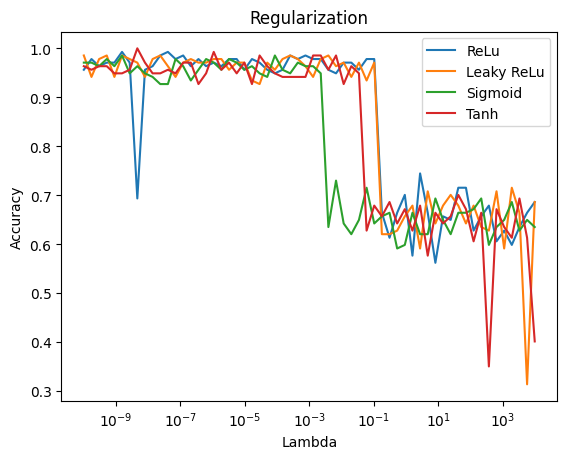

In [14]:
def search_lam(plot_or_not=False):
    lams = np.logspace(-10, 4, num=60)
    test_errs_all = {}
    train_errs_all = {}
    result = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lam in tqdm(lams):
            tqdm.write(f"Lambda: {lam}")
            result = single_run(X, y, lr=0.01, lam=lam, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func], test_index=result.get("test_index"))
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])
        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lams, test_errs, label=act_func)

    plt.legend()
    #plt.plot(lams, train_errs)
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Lambda")
    plt.xscale("log")
    plt.show()

    return {"lams":lams, "test_error":test_errs, "train_error":train_errs}

experiment = search_lam()

### Learning Rate search

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

  0%|          | 0/60 [00:00<?, ?it/s]

Learning rate: 1e-08
Learning rate: 1.4773776525985097e-08
Learning rate: 2.1826447283974873e-08
Learning rate: 3.224590545296398e-08
Learning rate: 4.7639380104013405e-08
Learning rate: 7.038135554931547e-08
Learning rate: 1.03979841848149e-07
Learning rate: 1.5361749466718295e-07
Learning rate: 2.2695105366946685e-07
Learning rate: 3.352924149249553e-07
Learning rate: 4.95353520895917e-07
Learning rate: 7.318242219076182e-07
Learning rate: 1.0811807510766079e-06
Learning rate: 1.5973122800602524e-06
Learning rate: 2.3598334667821937e-06
Learning rate: 3.4863652276780875e-06
Learning rate: 5.150678076168122e-06
Learning rate: 7.609496685459868e-06
Learning rate: 1.1242100350620863e-05
Learning rate: 1.6608827826277167e-05
Learning rate: 2.4537511066398168e-05
Learning rate: 3.6251170499885277e-05
Learning rate: 5.355666917706897e-05
Learning rate: 7.912342618981327e-05
Learning rate: 0.00011689518164985776
Learning rate: 0.00017269832906594324
Learning rate: 0.00025514065200312873
Lea

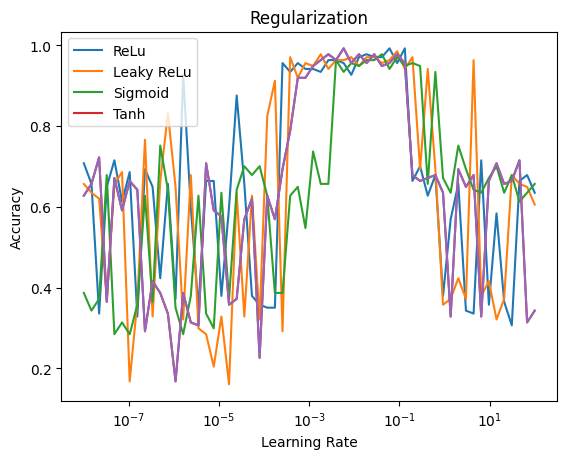

In [15]:

def search_lrs(plot_or_not=False):
    lrs = np.logspace(-8, 2, num=60)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for lr in tqdm(lrs):
            tqdm.write(f"Learning rate: {lr}")
            result = single_run(X, y, lr=lr, lam=0.00, hidden_layer_num=3, node_per_hidden=5, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(lrs, test_errs, label=act_func)

    plt.plot(lrs, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Learning Rate")
    plt.xscale("log")
    plt.show()

    return {"lrs":lrs, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_lrs()

### Note for report

The place with learning rate lower than e-4 is the place where the model sometimes has low enough initial gradients that when multiplied with the learning rate is rounded to zero and so the model becomes stuck and does not learn. Hence we see bad performance and alot of random variance in the results in this region.

### Layer Size

  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Hidden Layer size: 1
Hidden Layer size: 2
Hidden Layer size: 3
Hidden Layer size: 4
Hidden Layer size: 5
Hidden Layer size: 6
Hidden Layer size: 7
Hidden Layer size: 8
Hidden Layer size: 9
Hidden Layer size: 10
Hidden Layer size: 11
Hidden Layer size: 12
Hidden Layer size: 13
Hidden Layer size: 14
Hidden Layer size: 15
Hidden Layer size: 16
Hidden Layer size: 17
Hidden Layer size: 18
Hidden Layer size: 19
Hidden Layer size: 20
Hidden Layer size: 21
Hidden Layer size: 22
Hidden Layer size: 23
Hidden Layer size: 24
Hidden Layer size: 25
Hidden Layer size: 26
Hidden Layer size: 27
Hidden Layer size: 28
Hidden Layer size: 29


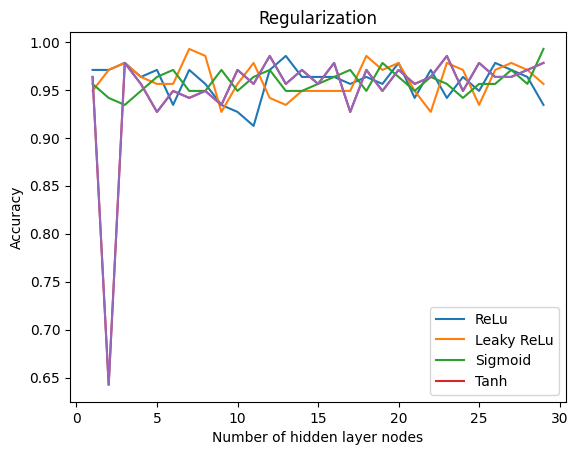

In [27]:

def search_hidden_layer_sizes(plot_or_not=False):
    hidden_layer_sizes = np.arange(1, 30)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_size in tqdm(hidden_layer_sizes):
            tqdm.write(f"Hidden Layer size: {hidden_layer_size}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=1, node_per_hidden=hidden_layer_size, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_sizes, test_errs, label=act_func)

    plt.plot(hidden_layer_sizes, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layer nodes")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_sizes, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_sizes()

  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Hidden Layer number: 1
Hidden Layer number: 2
Hidden Layer number: 3
Hidden Layer number: 4
Hidden Layer number: 5
Hidden Layer number: 6
Hidden Layer number: 7
Hidden Layer number: 8


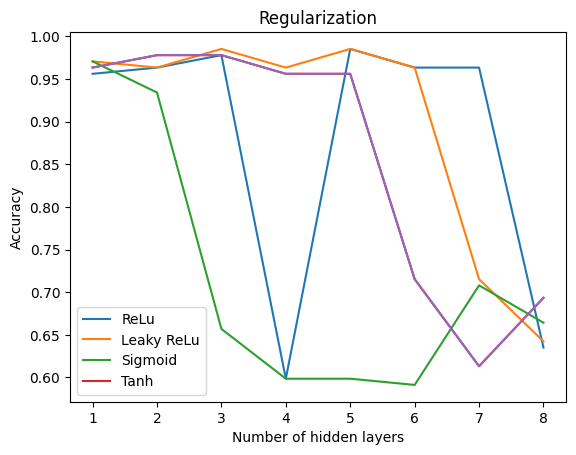

In [9]:

def search_hidden_layer_number(plot_or_not=False):
    hidden_layer_numbers = np.arange(1, 9)

    test_errs_all = {}
    train_errs_all = {}
    for act_func in activation_funcs.keys():
        test_errs = []
        train_errs = []
        for hidden_layer_number in tqdm(hidden_layer_numbers):
            tqdm.write(f"Hidden Layer number: {hidden_layer_number}")
            result = single_run(X, y, lr=0.01, lam=0.01, hidden_layer_num=hidden_layer_number, node_per_hidden=5, hidden_activation=activation_funcs[act_func])
            test_errs.append(result["test_loss_list"][-1])
            train_errs.append(result["train_loss_list"][-1])

        test_errs_all[act_func] = test_errs
        train_errs_all[act_func] = train_errs

        plt.plot(hidden_layer_numbers, test_errs, label=act_func)

    plt.plot(hidden_layer_numbers, test_errs)

    plt.legend()
    plt.title("Regularization")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of hidden layers")
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs, "train_error":train_errs}


#learning_rate_exp = search_lrs()
l = search_hidden_layer_number()

# Vary epochs maybe to show that the larger networks take longer

### ROC Curve

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


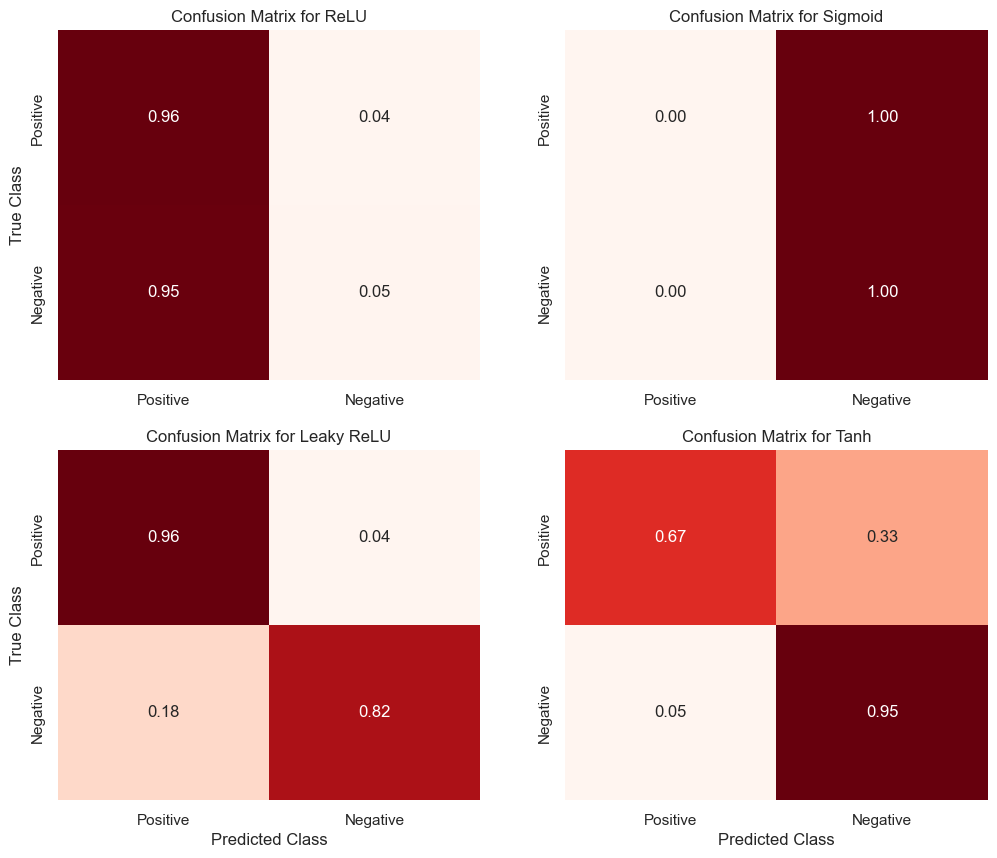

<Figure size 900x600 with 0 Axes>

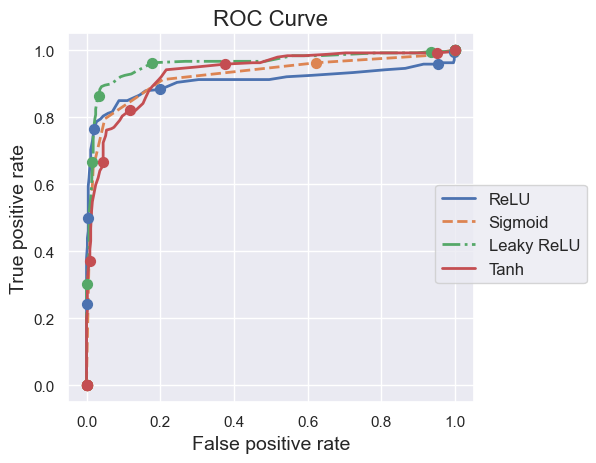

<Figure size 640x480 with 0 Axes>

In [69]:
def ROC(X, y, beta, model, method_name, linestyle, ax):
    thresholds = np.linspace(0, 1, 101)
    true_positive = []
    false_positive = []

    for th in thresholds:
        true_positive_func = true_pos_variable_func(model, th)
        false_positive_func = false_pos_variable_func(model, th)

        true_positive.append(true_positive_func(beta, X, y))
        false_positive.append(false_positive_func(beta, X, y))

    index = [10, 20, 30, 40,  50, 60, 70, 80, 90]
    false_positive = np.array(false_positive)
    true_positive = np.array(true_positive)
    print(thresholds[index])
    plt.figure(11)
    plt.plot(false_positive, true_positive, linestyle=linestyle, linewidth=2, label=f"{method_name}")
    plt.scatter(false_positive[index], true_positive[index], s=50, zorder=5) # s is the marker size
    # plt.ylim(0, 1)
    # plt.xlim(0, 1)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()

    tr_pos_f = true_pos_variable_func(model, 0.5)
    fa_pos_f = false_pos_variable_func(model, 0.5)

    confusion_matrix_values = [tr_pos_f(beta, X, y), 1 - tr_pos_f(beta, X, y), 
                               fa_pos_f(beta, X, y), 1 - fa_pos_f(beta, X, y)]

    plt.figure(2, figsize=(9, 6))
    # Reshape the list into a 2x2 array
    conf_matrix_array = np.array(confusion_matrix_values).reshape((2, 2))

    # Create a heatmap to display the matrix
    sns.set(color_codes=True)

    # Set the labels for the axes
    labels = ['Positive', 'Negative']

    # Use seaborn to create the heatmap
    sns.heatmap(conf_matrix_array, annot=True, fmt='.2f',
                xticklabels=labels, yticklabels=labels, cmap="Reds",
                ax=ax, cbar=False)

    ax.set_title(f'Confusion Matrix for {method_name}')
    


# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()
    

# Set a larger figure size
plt.figure(1, figsize=(10, 8))

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

line_styles = ['-', '--', '-.', '-']
lrs = [1e-2, 1e-3, 1e-4]
method_names = ["ReLU", "Sigmoid", "Leaky ReLU", "Tanh"]
methods = [nn.relu, nn.sigmoid, nn.leaky_relu, nn.tanh]

for i, method in enumerate(methods):
    result = single_run(X, y, 2e-4, 0.0001, hidden_layer_num=2, node_per_hidden=8, hidden_activation=method)
    ROC(X, y, result["beta_final"], result["model"], method_names[i], line_styles[i], axes[i])

axes[2].set_xlabel('Predicted Class')
axes[3].set_xlabel('Predicted Class')
axes[0].set_ylabel('True Class')
axes[2].set_ylabel('True Class')




plt.figure(11)
# Set labels and title
plt.xlabel("False positive rate", fontsize=14)
plt.ylabel("True positive rate", fontsize=14)
plt.title('ROC Curve', fontsize=16)

# Place the legend outside the plot
plt.legend(loc='lower right', fontsize=12, bbox_to_anchor=(1.3, 0.3))



# Show the plot
plt.tight_layout()
plt.show()


plt.figure(2)
plt.show()

C:\Users\eirik\AppData\Local\Temp\ipykernel_18536\3667809925.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_roc.show()
C:\Users\eirik\AppData\Local\Temp\ipykernel_18536\3667809925.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cm.show()


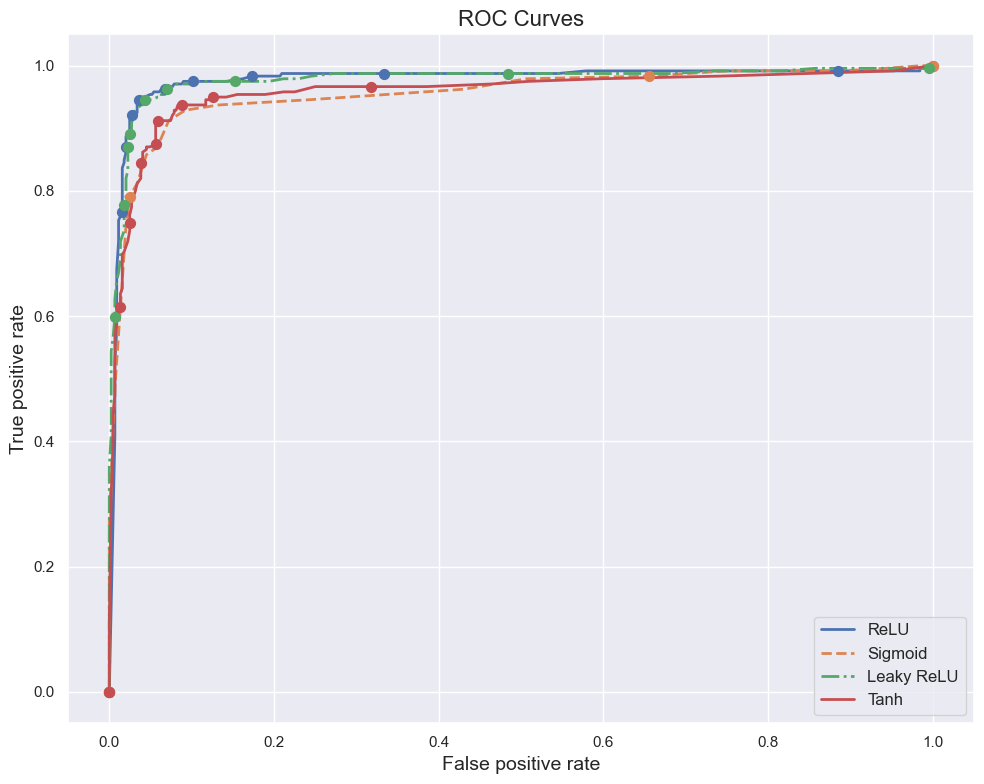

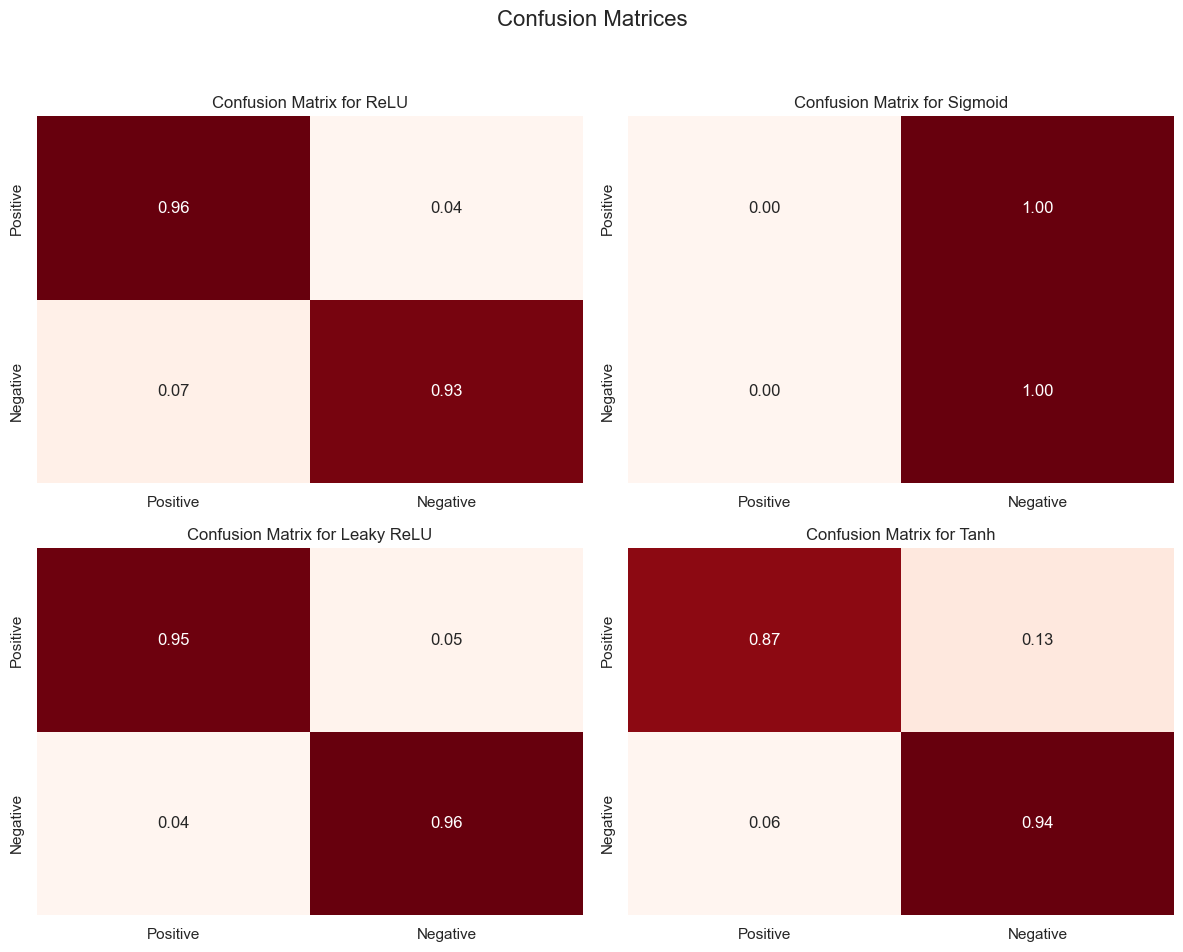

In [73]:
def plot_ROC(X, y, beta, model, method_name, linestyle, ax):
    index = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    # Calculate true and false positive rates
    thresholds = np.linspace(0, 1, 101)
    true_positive_rates = np.array([true_pos_variable_func(model, th)(beta, X, y) for th in thresholds])
    false_positive_rates = np.array([false_pos_variable_func(model, th)(beta, X, y) for th in thresholds])

    # Plot the ROC curve on the provided axis
    ax.plot(false_positive_rates, true_positive_rates, linestyle=linestyle, linewidth=2, label=method_name)
    ax.scatter(false_positive_rates[index], true_positive_rates[index], s=50, zorder=5)

def plot_confusion_matrix(X, y, beta, model, method_name, ax):
    # Calculate the confusion matrix values at threshold 0.5
    tp = true_pos_variable_func(model, 0.5)(beta, X, y)
    fp = false_pos_variable_func(model, 0.5)(beta, X, y)
    confusion_matrix_values = [tp, 1 - tp, fp, 1 - fp]

    # Reshape the list into a 2x2 array and plot the heatmap
    conf_matrix_array = np.array(confusion_matrix_values).reshape((2, 2))
    sns.heatmap(conf_matrix_array, annot=True, fmt='.2f', xticklabels=['Positive', 'Negative'], 
                yticklabels=['Positive', 'Negative'], cmap="Reds", ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {method_name}')

# Define styles and methods
line_styles = ['-', '--', '-.', '-']
method_names = ["ReLU", "Sigmoid", "Leaky ReLU", "Tanh"]
methods = [nn.relu, nn.sigmoid, nn.leaky_relu, nn.tanh]

# Create a single subplot for ROC curves
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

# Create a 2x2 subplot grid for confusion matrices
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(12, 10))
axes_cm = axes_cm.flatten()  # Flatten the axes array for easy iteration

# Generate plots for each method
for i, method in enumerate(methods):
    result = single_run(X, y, 8e-4, 0.0001, hidden_layer_num=2, node_per_hidden=8, hidden_activation=method)
    
    # Plot ROC curve on the same subplot
    plot_ROC(X, y, result["beta_final"], result["model"], method_names[i], line_styles[i], ax_roc)
    
    # Plot confusion matrix on separate subplots
    plot_confusion_matrix(X, y, result["beta_final"], result["model"], method_names[i], axes_cm[i])

# Finalize and show ROC curves
ax_roc.set_xlabel("False positive rate", fontsize=14)
ax_roc.set_ylabel("True positive rate", fontsize=14)
ax_roc.set_title('ROC Curves', fontsize=16)
ax_roc.legend(loc='lower right', fontsize=12)
fig_roc.tight_layout()
fig_roc.show()

# Finalize and show confusion matrices
fig_cm.suptitle('Confusion Matrices', fontsize=16)
fig_cm.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the suptitle
fig_cm.show()


### Learning rate and numer of hidden layers

Learning rate: 1e-06, Hidden Layer number: 1
Learning rate: 1e-06, Hidden Layer number: 2
Learning rate: 1e-06, Hidden Layer number: 3
Learning rate: 1e-06, Hidden Layer number: 4
Learning rate: 1e-06, Hidden Layer number: 5
Learning rate: 1e-06, Hidden Layer number: 6
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 1
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 2
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 3
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 4
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 5
Learning rate: 2.5118864315095822e-05, Hidden Layer number: 6
Learning rate: 0.000630957344480193, Hidden Layer number: 1
Learning rate: 0.000630957344480193, Hidden Layer number: 2
Learning rate: 0.000630957344480193, Hidden Layer number: 3
Learning rate: 0.000630957344480193, Hidden Layer number: 4
Learning rate: 0.000630957344480193, Hidden Layer number: 5
Learning rate: 0.000630957344480193, Hidden Layer number: 

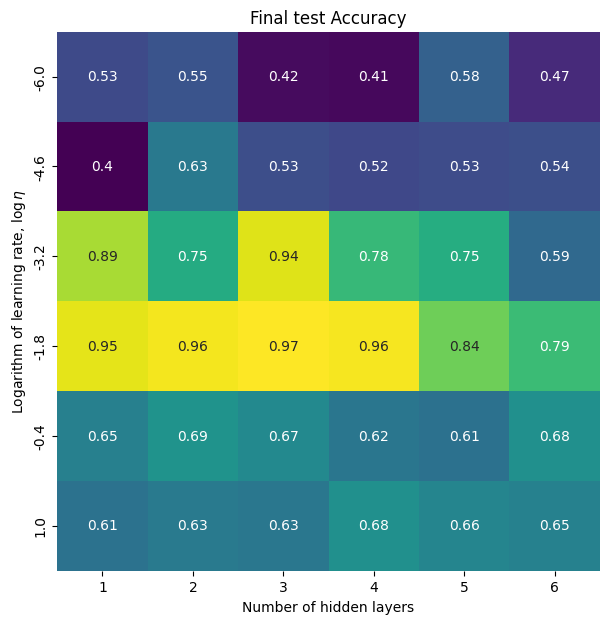

In [53]:
def learning_rate_hidden_layer_grid(plot_or_not=False):
    hidden_layer_numbers = np.arange(1, 7)
    lrs = np.logspace(-6, 1, 6)

    test_errs_all = np.zeros(shape=(6, 6))
    train_errs_all = np.zeros(shape=(6, 6))
    for i, lr in enumerate(lrs):
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
            tqdm.write(f"Learning rate: {lr}, Hidden Layer number: {hidden_layer_number}")
            s_test = 0.0
            s_train = 0.0
            for k in range(5):
                result = single_run(X, y, lr=lr, lam=0.01, hidden_layer_num=hidden_layer_number, node_per_hidden=5, hidden_activation=nn.leaky_relu)
                s_test += result["test_loss_list"][-1]
                s_train += result["train_loss_list"][-1]

            test_errs_all[i, j] = s_test/5
            train_errs_all[i, j] = s_train/5


    # Make sns heatmap
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=False)

    # Title
    ax.set_title("Final test Accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Logarithm of learning rate, $\log{\eta}$")

    ax.set_yticklabels(np.round(np.log10(lrs), 2))
    ax.set_xticklabels((hidden_layer_numbers))

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}


r= learning_rate_hidden_layer_grid()